In [ ]:
!sudo apt-get install cuda
!pip install -U git+https://github.com/albu/albumentations > /dev/null 
!pip install torch==1.6.0 torchvision==0.7.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cuda is already the newest version (11.2.1-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-qzrxbuso


In [ ]:
from __future__ import print_function

import albumentations as A

from collections import defaultdict, deque
import datetime
import pickle
import time
import torch.distributed as dist
import errno
from ast import literal_eval
import cv2

from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt 
import collections
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image, ImageFile
import pandas as pd
from tqdm import tqdm
from torchvision import transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
HEIGHT = 512
WIDTH = 512

# Utility Functions

In [ ]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        log_msg = self.delimiter.join([
            header,
            '[{0' + space_fmt + '}/{1}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}',
            'max mem: {memory:.0f}'
        ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                print(log_msg.format(
                    i, len(iterable), eta=eta_string,
                    meters=str(self),
                    time=str(iter_time), data=str(data_time),
                    memory=torch.cuda.max_memory_allocated() / MB))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def collate_fn(batch):
    return tuple(zip(*batch))


def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)

# Training Function

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
      
    if epoch%2==0:
      torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)

In [ ]:
def convert_to_mask(image, x_list, y_list):
    cropped = []
    boxes = []
    area = []
    # height, width, number of channels in image
    height, width, _ = image.shape
    mask_all = np.zeros(image.shape, dtype=np.float32)
    
    for x_string,y_string in zip(x_list, y_list):
        x = literal_eval(x_string)
        y = literal_eval(y_string)
        mask = np.zeros(image.shape[0:2], dtype=np.uint8)
        pts = []
        for j in range(len(x)):
            pts.append([x[j], y[j]])
        point = []
        point.append(pts)
        point = np.array(point, np.int32)

        cv2.fillPoly(mask, point, (255))
        res = cv2.bitwise_and(image,image,mask = mask)
        # print(mask_all.shape, res.shape)
        # print(type(mask_all), type(res))
        # print(mask_all.dtype, res.dtype)
        mask_all = cv2.bitwise_or(mask_all, res)
        

        #rect = cv2.boundingRect(point) # returns (x,y,w,h) of the rect
        #crop = res[rect[1]: rect[1] + rect[3], rect[0]: rect[0] + rect[2]]
        #crop = cv2.resize(crop,(width,height), interpolation = cv2.INTER_LINEAR)
        
        
        xmin = np.min(x)*WIDTH/width
        xmax = np.max(x)*WIDTH/width
        ymin = np.min(y)*HEIGHT/height
        ymax = np.max(y)*HEIGHT/height
        
        box = [xmin, ymin, xmax, ymax]
        #box = list(np.clip(np.array(box), 0.1, (WIDTH -1)))
        for i, values in enumerate(box):
          if values<=0.: 
            box[i] = 0.1
          if values>WIDTH-1:
            box[i] = WIDTH-1
        ar = (box[3] - box[1]) * (box[2] - box[0])
        #cropped.append(crop)
        boxes.append(box)
        area.append(ar)
    
    mask_all = cv2.resize(mask_all, (HEIGHT, WIDTH), interpolation = cv2.INTER_LINEAR)
    return mask_all, boxes, area

* # Road Crack Dataset Class

In [ ]:
class ROADCRACK(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['Id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
  

        image_id = self.image_ids[index]
        records = self.df[self.df['Id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image_new = cv2.resize(image, (HEIGHT, WIDTH), interpolation = cv2.INTER_LINEAR)


        ann = records[['X_points', 'Y_points']].values
        mask,boxes,area = convert_to_mask(image, ann[:,0], ann[:,1])
        
        mask = torch.as_tensor(mask, dtype=torch.float32)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = torch.as_tensor(area,  dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = mask.permute(2, 0, 1)
        #target['masks'] = mask
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        #print("image_id:{}; boxes_value:{}; mask_size:{}".format(image_id, target['boxes'], mask.size()))

#         if self.transforms:
#             sample = {
#                 'image': image,
#                 'bboxes': target['boxes'],
#                 'labels': labels
#             }
#             sample = self.transforms(**sample)
#             image = sample['image']
            
#             target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        image_new = torch.as_tensor(image_new, dtype=torch.float32)
        return image_new.permute(2, 0, 1), target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

# Read data

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Road Crack Detection/Road_obstacle_anamoly_detection/road/train_version5.csv")
train = train.reset_index()
train.head()

,index,Unnamed: 0,Id,Instance_Marker,X_points,Y_points,Area,Size,img_width,img_height,Area_256,Size_256,scale_x,scale_y,Unnamed: 0.1
0,0,0,road_001.jpg,0.0,"[533, 690, 733, 785, 828, 815, 715, 620, 526, ...","[481, 445, 442, 465, 486, 540, 560, 572, 572, ...",31293.5,large,1600.0,1060.0,1209.228075,medium,0.000625,0.000943,NaN
1,1,1,road_001.jpg,1.0,"[420, 456, 479, 502, 602, 733, 829, 908, 896, ...","[663, 654, 626, 606, 592, 576, 576, 592, 635, ...",48961.5,large,1600.0,1060.0,1891.946264,medium,0.000625,0.000943,NaN
2,2,2,road_001.jpg,2.0,"[683, 794, 910, 947, 1030, 1085, 1098, 1042, 9...","[762, 737, 738, 747, 756, 810, 878, 908, 940, ...",79661.5,large,1600.0,1060.0,3078.240604,medium,0.000625,0.000943,NaN
3,3,3,road_001.jpg,3.0,"[177, 291, 315, 218, 166, 154]","[701, 674, 679, 703, 726, 715]",1932.0,medium,1600.0,1060.0,74.655396,small,0.000625,0.000943,NaN
4,4,4,road_001.jpg,4.0,"[872, 942, 1064, 1074, 1167, 1189, 1160, 1139,...","[270, 282, 290, 277, 284, 263, 247, 234, 241, ...",10429.5,large,1600.0,1060.0,403.011623,small,0.000625,0.000943,NaN


In [ ]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Create Dataset

In [ ]:
dataset_train = ROADCRACK(train, "/content/drive/MyDrive/Road Crack Detection/Road_obstacle_anamoly_detection/road/all_images/train")

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_data_loader = DataLoader(
    dataset_train,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)


In [ ]:
device = torch.cuda.set_device(0)

# Sample

In [ ]:
images, targets = next(iter(train_data_loader))
#images = list(torch.as_tensor(image).to(device) for image in images)
targets = [{k: torch.as_tensor(v).to(device) for k, v in t.items()} for t in targets]

image_id:road_005.jpg; boxes_value:tensor([[  1.0240, 170.1463, 393.2160, 446.4390],
        [279.5520, 101.4634, 362.4960, 134.2439],
        [423.9360, 115.5122, 506.8800, 163.9024]]); mask_size:torch.Size([512, 512, 3])
image_id:road_006.jpg; boxes_value:tensor([[ 11.2640, 186.7673, 408.5760, 476.5786],
        [253.9520, 119.1447, 508.9280, 189.9874],
        [193.5360,  86.9434, 249.8560, 119.1447]]); mask_size:torch.Size([512, 512, 3])
image_id:road_007.jpg; boxes_value:tensor([[  2.0480, 171.6979, 506.8800, 507.3595]]); mask_size:torch.Size([512, 512, 3])
image_id:road_008.jpg; boxes_value:tensor([[247.8080,  96.9387, 508.9280, 146.7733],
        [  2.5600, 169.9840, 393.7280, 509.2693],
        [ 99.8400, 126.9760, 146.4320, 148.1387]]); mask_size:torch.Size([512, 512, 3])
image_id:road_001.jpg; boxes_value:tensor([[160.6400, 213.4943, 264.9600, 276.2868],
        [119.6800, 278.2189, 290.5600, 345.3585],
        [185.9200, 355.9849, 351.3600, 455.0038],
        [ 49.2800, 325.

In [ ]:
print(len(images))

4


In [ ]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.float32)
print(boxes)
sample = images[0]
mask = targets[0]['masks'].cpu().numpy().transpose(1, 2, 0)


[[160.64      213.49434   264.96      276.2868   ]
 [119.68      278.21887   290.56      345.3585   ]
 [185.92      355.9849    351.36      455.00378  ]
 [ 49.28      325.55472   100.8       350.6717   ]
 [279.04      113.02641   380.48      140.07547  ]
 [342.72        2.4150944 428.48       15.456604 ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


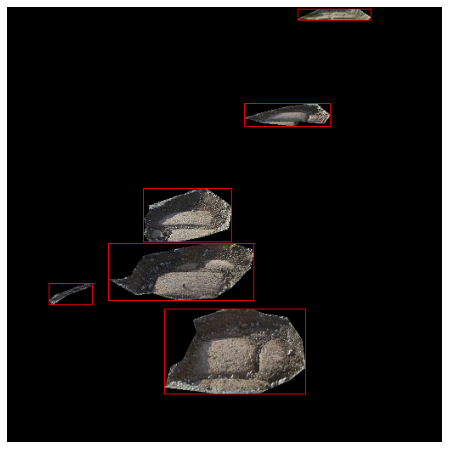

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(mask,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (255, 0, 0), 1)
    
ax.set_axis_off()
print(mask.shape)
ax.imshow(mask)

# Train 

In [ ]:
# create mask rcnn model
num_classes = 2

model_ft = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
in_features_mask = model_ft.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model_ft.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
model_ft.to(device)

for param in model_ft.parameters():
    param.requires_grad = True

In [ ]:
params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00001, momentum=0.9, weight_decay=0.00005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
!nvidia-smi 

Sun Feb 28 02:31:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.version.cuda

'10.2'

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 2
for epoch in range(num_epochs):
    train_one_epoch(model_ft, optimizer, train_data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()

image_id:road_005.jpg; boxes_value:tensor([[  1.0240, 170.1463, 393.2160, 446.4390],
        [279.5520, 101.4634, 362.4960, 134.2439],
        [423.9360, 115.5122, 506.8800, 163.9024]]); mask_size:torch.Size([512, 512, 3])
image_id:road_006.jpg; boxes_value:tensor([[ 11.2640, 186.7673, 408.5760, 476.5786],
        [253.9520, 119.1447, 508.9280, 189.9874],
        [193.5360,  86.9434, 249.8560, 119.1447]]); mask_size:torch.Size([512, 512, 3])
image_id:road_007.jpg; boxes_value:tensor([[  2.0480, 171.6979, 506.8800, 507.3595]]); mask_size:torch.Size([512, 512, 3])
image_id:road_008.jpg; boxes_value:tensor([[247.8080,  96.9387, 508.9280, 146.7733],
        [  2.5600, 169.9840, 393.7280, 509.2693],
        [ 99.8400, 126.9760, 146.4320, 148.1387]]); mask_size:torch.Size([512, 512, 3])
image_id:road_013.jpg; boxes_value:tensor([[211.8892, 190.2916, 330.8308, 206.0616],
        [  0.7877, 209.2156, 511.0000, 510.9487],
        [371.7908, 178.7269, 426.9292, 192.3943],
        [ 41.7477, 194.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


image_id:road_018.jpg; boxes_value:tensor([[174.4000, 302.9333, 256.8000, 392.5333],
        [292.8000, 418.1333, 380.0000, 452.2667],
        [155.2000, 420.2667, 192.8000, 444.8000],
        [270.4000, 370.1333, 398.4000, 392.5333]]); mask_size:torch.Size([512, 512, 3])
image_id:road_019.jpg; boxes_value:tensor([[281.6000, 315.7333, 350.4000, 354.1333],
        [385.6000, 421.3333, 442.4000, 460.8000],
        [132.8000, 234.6667, 200.0000, 300.8000],
        [245.6000, 230.4000, 325.6000, 280.5333],
        [175.2000, 310.4000, 212.0000, 332.8000],
        [140.0000, 331.7333, 172.0000, 359.4667],
        [291.2000, 211.2000, 341.6000, 238.9333]]); mask_size:torch.Size([512, 512, 3])
image_id:road_020.jpg; boxes_value:tensor([[ 48.8369, 177.4257, 254.4246, 444.8317],
        [284.3569,  84.9109, 508.8492, 484.1188]]); mask_size:torch.Size([512, 512, 3])
Epoch: [0]  [  0/264]  eta: 4:31:14  lr: 0.000000  loss: 4.1448 (4.1448)  loss_classifier: 0.3887 (0.3887)  loss_box_reg: 0.2646 (0